# Temperature Salinity Plots

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import pandas as pd
import xarray as xr

import datashader as ds
import datashader.transfer_functions as tf
from datashader.colors import Hot

import dask.array as da
import dask.dataframe as dd

Let's compare different ways of plotting TS diagrams.

In [2]:
filename = '/g/data1/v45/mom01_comparison/KDS75/output165/ocean.nc'

## Loading with netCDF4

In [3]:
%%time 
from netCDF4 import Dataset

dataset = Dataset(filename)
temp = dataset.variables['temp'][:].ravel()
salt = dataset.variables['salt'][:].ravel()

CPU times: user 51 s, sys: 4.73 s, total: 55.7 s
Wall time: 55.8 s


In [ ]:
df = pd.DataFrame({'temp': temp, 'salt' : salt}, copy=False)

In [4]:
whos

Variable   Type           Data/Info
-----------------------------------
Dataset    type           <class 'netCDF4._netCDF4.Dataset'>
dataset    Dataset        <class 'netCDF4._netCDF4.<...>(time,nv)\n    groups: \n
filename   str            /g/data1/v45/mom01_compar<...>/KDS75/output165/ocean.nc
salt       MaskedArray    [-- -- -- ..., -- -- --]
temp       MaskedArray    [-- -- -- ..., -- -- --]


In [6]:
dataset.variables['temp']

<class 'netCDF4._netCDF4.Variable'>
float32 temp(time, st_ocean, yt_ocean, xt_ocean)
    long_name: Potential temperature
    units: degrees C
    valid_range: [ -10.  500.]
    missing_value: -1e+20
    _FillValue: -1e+20
    cell_methods: time: mean
    time_avg_info: average_T1,average_T2,average_DT
    coordinates: geolon_t geolat_t
    standard_name: sea_water_potential_temperature
unlimited dimensions: time
current shape = (1, 75, 2700, 3600)
filling on

temp and salt are numpy MaskedArrays

In [12]:
temp = temp.ravel()
salt = salt.ravel()

In [17]:
import pandas as pd

df = pd.DataFrame({'temp': temp, 'salt' : salt}, copy=False)

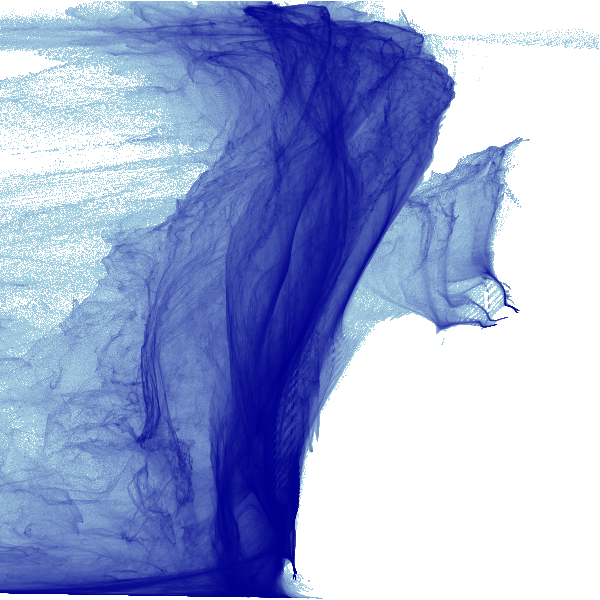

In [24]:
cvs = ds.Canvas(x_range=(30,40), y_range=(-2,30))
agg = cvs.points(df, 'salt', 'temp', agg=ds.count())
tf.shade(agg)

In [2]:
from dask.distributed import Client, LocalCluster

In [23]:
cluster.status

'closed'

In [3]:
cluster = LocalCluster(n_workers=4, threads_per_worker=1)

In [4]:
client = Client(cluster)

In [21]:
client.restart()

<Client: scheduler='tcp://127.0.0.1:8786' processes=0 cores=0>

In [2]:
filename = '/g/data1/v45/mom01_comparison/KDS75/output165/ocean.nc'

In [3]:
dsx = xr.open_dataset(filename, decode_times=False)

In [4]:
%%time
df = dd.from_array( np.array([dsx.temp.values.ravel(), dsx.salt.values.ravel()]).T, \
                                    columns = ['temp', 'salt'])

CPU times: user 1min 21s, sys: 10.7 s, total: 1min 31s
Wall time: 1min 31s


In [4]:
%%time
df = pd.DataFrame({'temp': dsx.temp.to_series(), 'salt': dsx.salt.to_series()})

CPU times: user 2min 4s, sys: 1min 3s, total: 3min 8s
Wall time: 3min 8s


In [20]:
# Default plot ranges:
y_range = (-2, 40)
x_range = (0, 40)

In [21]:
def create_image(x_range=x_range, y_range=y_range, w=500, h=500):
    cvs = ds.Canvas(x_range=x_range, y_range=y_range, plot_height=h, plot_width=w)
    agg = cvs.points(df, 'salt', 'temp', agg=ds.count())
    return tf.shade(agg)

In [22]:
%%time 
img = create_image(x_range = (32, 38))

CPU times: user 28.9 s, sys: 7.03 s, total: 35.9 s
Wall time: 24.2 s


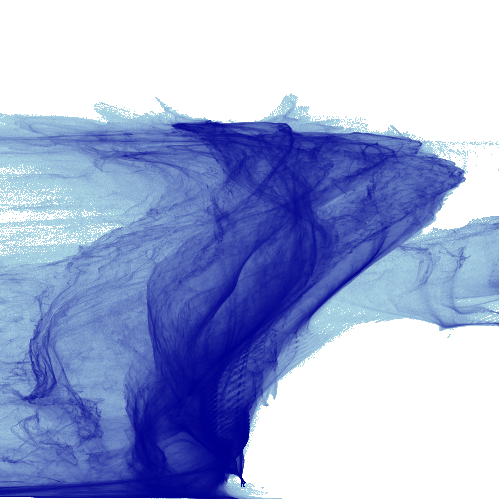

In [23]:
img

In [24]:
from datashader.bokeh_ext import InteractiveImage
import bokeh.plotting as bp
bp.output_notebook()

def base_plot(tools='pan,wheel_zoom,box_zoom,reset'):
    p = bp.figure(tools=tools, plot_width=500, plot_height=500,
        x_range=x_range, y_range=y_range, outline_line_color=None,
        min_border=0, min_border_left=0, min_border_right=0,
        min_border_top=0, min_border_bottom=0)   
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None
    p.xaxis.axis_label = 'Salinity'
    p.yaxis.axis_label = 'Potential Temperature'
    return p

p = base_plot()
InteractiveImage(p, create_image)


Loading BokehJS ...

In [ ]:
%%time
cvs = ds.Canvas()
agg = cvs.points(df, 'salt', 'temp')
img = tf.shade(agg)

In [ ]:
from bokeh.plotting import figure, output_notebook, show
output_notebook()

In [ ]:
# convert to pandas dataframe
%time df = dsx.temp.to_dataframe()

In [ ]:
# convert to pandas dataframe
%time df = dsx.temp.to_dataframe()

In [ ]:
%time df2 = dsx.salt.to_dataframe()

In [ ]:
df3 = df.merge(df2)

In [ ]:
stacked = dsx.temp.stack(z = ('st_ocean', 'xt_ocean', 'yt_ocean'))

In [ ]:
stacked.z

In [ ]:
%time dataset.u.plot.hist(bins=100)

In [ ]:
%%time 
agg = cvs.points(df, 'geolon_t', 'geolat_t', ds.count('temp'))

img = tf.shade(agg, how='log')
img

In [ ]:
img = tf.shade(agg, how='log')

In [ ]:
from dask import delayed

@delayed
def get_data(key):
    ncfile = '/g/data1/v45/mom01_comparison/KDS75_wind/output165/ocean.nc'
    h5 = h5py.File(ncfile, mode='r')
    arr = dd.from_array(h5['/'+key][:].ravel(), columns = [key])
    h5.close()
    return arr

temp = get_data('temp')
print('temp loaded')
salt = get_data('salt')
print('salt loaded')

#arr = delayed(np.hstack)((temp, salt))
print(arr.shape)
#df = delayed(dd.from_array)( arr, columns = ['temp', 'salt'])
print(df)

In [ ]:
ncfile = '/g/data1/v45/mom01_comparison/KDS75_wind/output165/ocean.nc'
dsx = xr.open_dataset(ncfile, decode_times=False, engine='h5netcdf')

In [ ]:
from dask import delayed

@delayed
def get_data(key):
    ncfile = '/g/data1/v45/mom01_comparison/KDS75_wind/output165/ocean.nc'
    dsx = xr.open_dataset(ncfile, decode_times=False, engine='h5netcdf')
    arr = dsx.variables(key).values.ravel()
    dsx.close()
    return arr

df = dd.from_array( np.array( [ dsx.temp.values.ravel(), dsx.salt.values.ravel()]).T, 
              columns=['temp', 'salt'])

In [ ]:
dsx = xr.open_dataset(ncfile, decode_times=False, engine='h5netcdf', chunks={'st_ocean':1, 'sw_ocean':1})

In [ ]:
%%time
df = dd.from_array( np.array( [ dsx.temp.values.ravel(), dsx.salt.values.ravel()]).T,
                  columns = ('temp', 'salt'))

In [ ]:
df = delayed(dd.merge)(temp, salt)

In [ ]:
df.visualize()

In [ ]:
%%time
df2 = df.compute()

In [ ]:
ncfile = '/g/data1/v45/mom01_comparison/KDS75_wind/output165/ocean.nc'
dd.read_hdf(ncfile, 'temp')